# **Multiple Linear Regression in Action: A Practical Case Study**

### **Libraries Used**

In [31]:
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from tabulate import tabulate
from typing import NamedTuple, List, Dict, Tuple, Union

from scratch.complex_typing import Vector
from scratch.data_preprocessing import split_data

### **Introduction**

In real-world data analysis, outcomes are rarely determined by a single factor. Whether you’re predicting house prices, exam scores, or customer behavior, it’s often necessary to consider multiple variables at once. This is where multiple regression comes in.

Multiple regression is a statistical method used to model the relationship between one dependent variable and two or more independent variables. It allows us to estimate the influence of each predictor while accounting for the presence of others.

Unlike simple linear regression—which uses only one predictor—multiple regression gives us a more realistic and powerful framework for understanding complex data. It is widely used in economics, biology, engineering, social sciences, and machine learning.

### **Theoretical Framework**

**The Multiple Linear Regression Model**

Multiple linear regression is a method used to model the relationship between a single dependent variable and two or more independent variables. It helps us understand how changes in several predictors affect the outcome we’re interested in.

The general form of the model is:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \varepsilon
$$

Where:
* $y$ is the response variable (what we want to predict or explain).
* $x_1, x_2, \dots, x_p$ are the predictor variables (features or inputs).
* $\beta_0$ is the intercept, representing the expected value of $y$ when all $x_i = 0$.
* $\beta_1, \beta_2, \dots, \beta_p$ are the regression coefficients, which measure the effect of each predictor on $y$, assuming all other variables are held constant.
* $\varepsilon$ is the error term, accounting for random variation not explained by the model.

Each $\beta_i$ answers the question:

“If all other variables stay the same, how much does $y$ change when $x_i$ increases by one unit?”

The goal of multiple regression is to estimate the values of the coefficients $\beta_0, \beta_1, \dots, \beta_p$ from data so we can:
* Understand relationships between variables,
* Make predictions for new data,
* Identify which predictors are most important.


**Assumptions of the Classical Linear Model**

For the least squares estimator to be unbiased and have minimum variance, the following assumptions must hold:
1. Linearity: The relationship between $y$ and the predictors is linear in the coefficients.
2. Independence: The errors $\varepsilon_i$ are independent.
3. Homoscedasticity: The errors have constant variance, i.e., $\text{Var}(\varepsilon_i) = \sigma^2$.
4. Normality: The errors are normally distributed (required for inference).
5. No multicollinearity: The predictors are not perfectly linearly correlated.

Violating these assumptions—especially multicollinearity—can severely affect coefficient estimates.

**Ridge Regularization**

In multiple regression, unstable or overly large coefficients can occur when predictors are highly correlated. Ridge regression fixes this by adding a penalty to the usual regression loss function.

Instead of minimizing the Residual Sum of Squares (RSS) alone:

$$
\text{RSS} = \sum_{i=1}^{n} \left( \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip} -y_i\right)^2
$$

Ridge regression minimizes the following penalized loss function:

$$
\text{Loss}{\text{ridge}} = \sum_{i=1}^{n} \left( \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij} - y_i\right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
$$

Where:
* $n$ is the number of observations,
* $p$ is the number of predictors,
* $x_{ij}$ is the value of predictor $j$ for observation $i$,
* $\lambda \geq 0$ is the regularization parameter,
* The first term is the squared error (as in ordinary least squares),
* The second term is the penalty that discourages large coefficient values.

**Standard error of the cofficients**

In practice, we often want to estimate the uncertainty of each coefficient—this is typically done by calculating the standard error of the coefficients.

One robust, assumption-free method is bootstrapping, which involves:
1. Resampling the original data (with replacement) to create many “bootstrap samples.”
2. Fitting the regression model on each sample to obtain a set of coefficient estimates.
3. Computing the standard deviation of the bootstrap estimates for each coefficient.
4. Once the standard error of a coefficient is known, we can perform a hypothesis test to determine whether the coefficient is statistically significant — in particular, whether it is likely to be zero in the population.

Bootstrapping is particularly valuable when the usual assumptions (e.g., normality or homoscedasticity) are in doubt.

Keep reading to explore the step-by-step process of a multiple regression process and see it in action with a practical example.

### **Practical Example**

We’ll start by loading the data from a CSV file into a Pandas DataFrame. Although we will construct our model from scratch later, using a DataFrame at this stage allows us to efficiently explore and analyze the structure of the dataset, thanks to its optimized handling of tabular data. Moreover, this format is widely supported by current data science libraries, which natively operate on Pandas DataFrames for tasks such as preprocessing, visualization, and modeling.

In [2]:
df = pd.read_csv("datasets/students_performance.csv")

# Make a copy for make some needed adjusts.
df_adjusted = df.copy()

We will define a function to generate a comprehensive summary of our dataset.

In [3]:
def summary(df):
    """
    Prints a detailed summary of each column in a pandas DataFrame.
    Shows type, missing values, and descriptive statistics for each column.
    """
    print(f"\nDataFrame Summary: {df.shape[0]} rows, {df.shape[1]} columns")
    print("=" * 60)

    for col in df.columns:
        print(f"\nColumn: {col}")
        print(f"Type: {df[col].dtype}")
        print(f"Missing values: {df[col].isna().sum()}")

        if pd.api.types.is_numeric_dtype(df[col]):
            print(f"Mean: {df[col].mean():.5f}")
            print(f"Median: {df[col].median():.5f}")
            print(f"Min: {df[col].min():.5f}")
            print(f"Max: {df[col].max():.5f}")
            print(f"Standard Deviation: {df[col].std():.5f}")
        elif pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            print("Value counts:")
            print(df[col].value_counts())
        elif pd.api.types.is_bool_dtype(df[col]):
            print("Value counts:")
            print(df[col].value_counts())
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            print(f"Min date: {df[col].min():.5f}")
            print(f"Max date: {df[col].max():.5f}")
        else:
            print("Unrecognized or complex data type.")

    print("\n" + "=" * 60 + "\nEnd of summary.\n")

In [4]:
summary(df)


DataFrame Summary: 10000 rows, 6 columns

Column: Hours Studied
Type: int64
Missing values: 0
Mean: 4.99290
Median: 5.00000
Min: 1.00000
Max: 9.00000
Standard Deviation: 2.58931

Column: Previous Scores
Type: int64
Missing values: 0
Mean: 69.44570
Median: 69.00000
Min: 40.00000
Max: 99.00000
Standard Deviation: 17.34315

Column: Extracurricular Activities
Type: object
Missing values: 0
Value counts:
Extracurricular Activities
No     5052
Yes    4948
Name: count, dtype: int64

Column: Sleep Hours
Type: int64
Missing values: 0
Mean: 6.53060
Median: 7.00000
Min: 4.00000
Max: 9.00000
Standard Deviation: 1.69586

Column: Sample Question Papers Practiced
Type: int64
Missing values: 0
Mean: 4.58330
Median: 5.00000
Min: 0.00000
Max: 9.00000
Standard Deviation: 2.86735

Column: Performance Index
Type: float64
Missing values: 0
Mean: 55.22480
Median: 55.00000
Min: 10.00000
Max: 100.00000
Standard Deviation: 19.21256

End of summary.



Based on the summary statistics, we observe the following structure in the dataset:
Predictor Variables:
- Hours Studied: Number of hours the student dedicated to studying.
- Previous Scores: Student’s previous academic performance scores.
- Extracurricular Activities: Indicates whether the student participates in extracurricular activities (“Yes” or “No”).
- Sleep Hours: Average number of hours the student sleeps per day.
- Sample Question Papers Practiced: Number of sample question papers the student practiced, ranging from 0 to 9.
Target Variable:
- Performance Index: Represents the final performance score, which we aim to predict.

The dataset is complete—there are no missing values—so no imputation is required. The only preprocessing step needed is converting the “Extracurricular Activities” column into a numerical format using dummy (binary) encoding, as it is currently categorical.

It's a convention that we shouldn't use space in our col names, so we better change it.

In [5]:
# Modify the columns names, strip blank spaces at the beggining and at the end, also replace spaces between words
df_adjusted.columns = [col_name.strip().lower().replace(" ","_") for col_name in df.columns]
# Transform str labels into dummies variables (we can even use a one hot encoder)
df_adjusted['extracurricular_activities'] = [1 if i=="Yes" else 0 for i in df_adjusted['extracurricular_activities']]
print(tabulate(df_adjusted.iloc[:5,], headers='keys', tablefmt='psql'))

+----+-----------------+-------------------+------------------------------+---------------+------------------------------------+---------------------+
|    |   hours_studied |   previous_scores |   extracurricular_activities |   sleep_hours |   sample_question_papers_practiced |   performance_index |
|----+-----------------+-------------------+------------------------------+---------------+------------------------------------+---------------------|
|  0 |               7 |                99 |                            1 |             9 |                                  1 |                  91 |
|  1 |               4 |                82 |                            0 |             4 |                                  2 |                  65 |
|  2 |               8 |                51 |                            1 |             7 |                                  2 |                  45 |
|  3 |               5 |                52 |                            1 |             5 |   

**Correlation matrix**

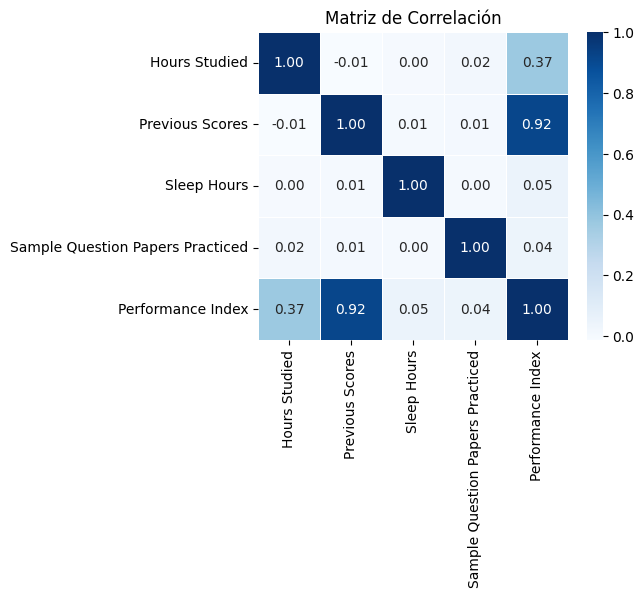

In [6]:
# Calcular la matriz de correlación
corr_matrix = df.corr(numeric_only=True)

# Crear el mapa de calor (heatmap)
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

Analyzing the correlation matrix yields the following insights:
- Low Multicollinearity: 
    - The predictor variables are not strongly correlated with each other — all pairwise correlations are far from ±1 — suggesting low multicollinearity, which is desirable for multiple linear regression.
- Relationship with the Target Variable:
    - Hours Studied and Previous Scores show the strongest linear relationships with the Performance Index, with correlation coefficients of approximately 0.37 and 0.91, respectively.
    - These two predictors are likely to contribute more significantly to explaining the variability in the target variable compared to Sleep Hours and Sample Question Papers Practiced, which show weaker correlations.

Next, we will examine the potential linear relationships between the target variable and each predictor through visualization.

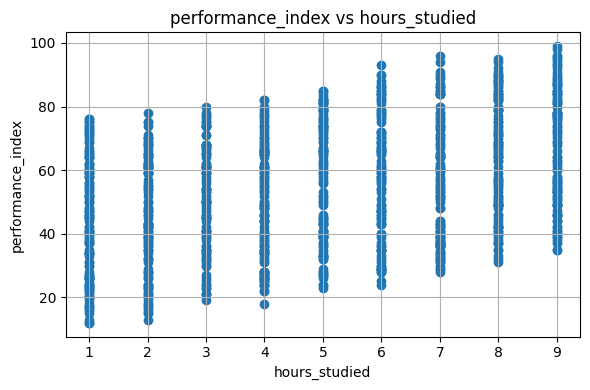

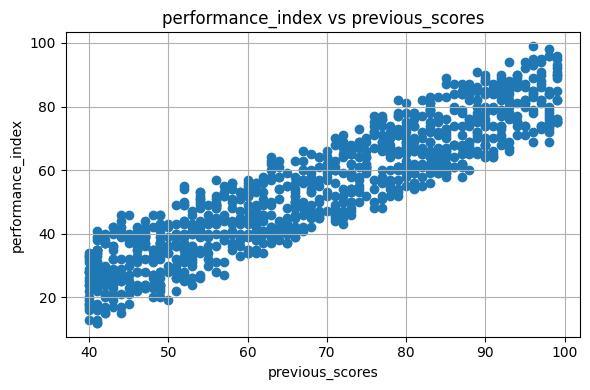

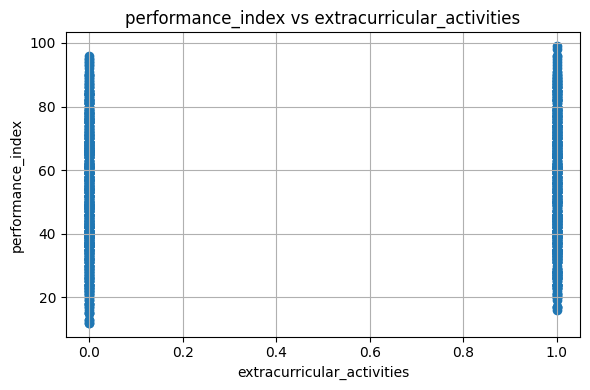

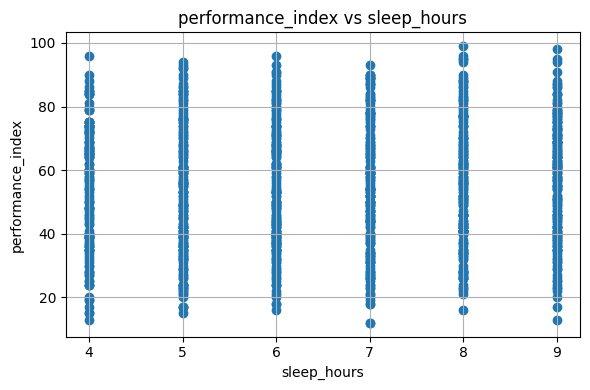

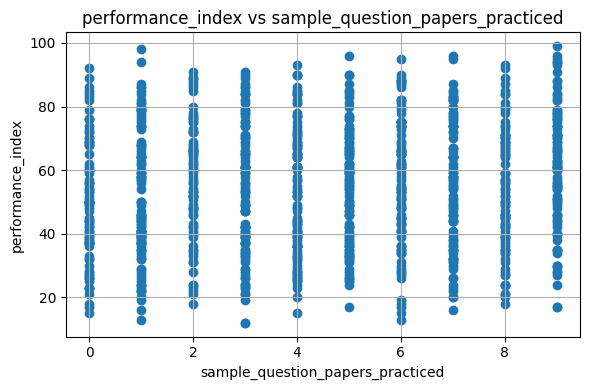

In [7]:
y_col = 'performance_index'
sample = df_adjusted.sample(n=1000)
for x_col in sample.columns:
    if x_col == y_col:
        continue

    plt.figure(figsize=(6, 4))
    plt.scatter(sample[x_col], sample[y_col], marker='o')
    plt.title(f'{y_col} vs {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The scatter plots visually confirm the insights from the correlation matrix:
- Previous Scores exhibits a strong positive linear relationship with the Performance Index, as expected from its high correlation (~0.92). This suggests it is a very strong predictor.
- Hours Studied shows a moderate positive linear trend with the target variable, aligning with its moderate correlation (~0.37).
- Sleep Hours and Sample Question Papers Practiced display weak or no clear linear patterns with the target, consistent with their very low correlations (~0.04), indicating limited predictive power in a linear model.

Overall, the plots support using Previous Scores and Hours Studied as primary predictors in the linear regression model, while the other variables may have a minor or negligible linear effect.

We will begin by running the initial analysis using all the variables. Later, we will refine the model by removing predictors that do not show a meaningful linear relationship with the Performance Index (our target variable).

Next, we will represent each student as an individual object containing their respective attribute values.

In [8]:
class Student(NamedTuple):
    """
    A class to represent a student
    """
    features_names: List[str]
    features_vector: Vector
    target_name: str
    target_value: float


Now, we need to clearly define our predictor variables and the target variable. We will use all variables except Performance Index as predictors. Additionally, to evaluate our model properly, we must split the data into training and testing sets. Let’s proceed to prepare these components.

In [9]:
# Define predictors and target variables. 
features_names = [col for col in df_adjusted.columns if col!="performance_index"] # All except performance_index
target_name = "performance_index"

# We will convert the df to a list of objects that represent each student, using a data frame it's better
# if we talk about efficiency but we will do this and we will work from scratch.

rows = df_adjusted.shape[0]
cols = df_adjusted.shape[1]
students = []

# We itrarte each row of the pandas dataframe and convert it in a List of students.
for i in range(df_adjusted.shape[0]):
    vector_values = []
    target_value = df_adjusted.loc[i, target_name].item()
    for col in features_names:
        vector_values.append(df_adjusted.loc[i, col].item())
    students.append(Student(features_names=features_names, 
                                    features_vector=vector_values, 
                                    target_name=target_name, 
                                    target_value=target_value))

We now have a list of students.

Each student’s information is stored in their attributes. Let’s examine the first five students to see how their data is represented:

In [10]:
for i in range(5):
    student = students[i]
    print(f"\n===== Student {i+1} =====")
    print(f"Features Names : {student.features_names}")
    print(f"Features Vector: {student.features_vector}")
    print(f"Target Name    : {student.target_name}")
    print(f"Target Value   : {student.target_value}")


===== Student 1 =====
Features Names : ['hours_studied', 'previous_scores', 'extracurricular_activities', 'sleep_hours', 'sample_question_papers_practiced']
Features Vector: [7, 99, 1, 9, 1]
Target Name    : performance_index
Target Value   : 91.0

===== Student 2 =====
Features Names : ['hours_studied', 'previous_scores', 'extracurricular_activities', 'sleep_hours', 'sample_question_papers_practiced']
Features Vector: [4, 82, 0, 4, 2]
Target Name    : performance_index
Target Value   : 65.0

===== Student 3 =====
Features Names : ['hours_studied', 'previous_scores', 'extracurricular_activities', 'sleep_hours', 'sample_question_papers_practiced']
Features Vector: [8, 51, 1, 7, 2]
Target Name    : performance_index
Target Value   : 45.0

===== Student 4 =====
Features Names : ['hours_studied', 'previous_scores', 'extracurricular_activities', 'sleep_hours', 'sample_question_papers_practiced']
Features Vector: [5, 52, 1, 5, 2]
Target Name    : performance_index
Target Value   : 36.0

===

Lastly, we will divide the data into training and test sets for model evaluation.

In [11]:
random.seed(12)
students_raw = students.copy()
train_students, test_students = split_data(students, proportion=0.80)

Now we must get the X, y vector for the model training:
- x_vals = [[vector with features of student 1], [vector with features of student 2] ...]
- y_vals = [y student 1, y student 2, ...]

In this part we will chose wich variables will be our predictors and which our target

In [12]:
# At this point we will take all our features as potential predictors
predictors = ['hours_studied', 
              'previous_scores',
              'extracurricular_activities',
              'sleep_hours',
              'sample_question_papers_practiced']

target = 'performance_index'

# We took the data of the predictors we want for each student in training set
x_train_students_data = [list(zip(*(student.features_names, student.features_vector))) for student in train_students]
x_train_vals = [
    [pairs[1] for pairs in student_data if pairs[0] in predictors] 
          for student_data in x_train_students_data
]

y_train_vals = [student.target_value for student in train_students]

We also need to consider normalize the data in order to get
1.	Balanced Feature Influence: Prevents large-scale features from dominating updates.
2.	Stable Learning Rate: Allows using a reasonable learning rate without divergence.
3.	Numerical Stability: Reduces risk of overflow or underflow during calculations.

Let's code an easy function to normalize our data

In [13]:
# Normalize data functions
def print_normalization_parameters(params: Dict[str, Dict[str, Union[float, str]]]) -> None:
    """
    Nicely prints the normalization parameters dictionary.
    
    Parameters:
        params: Dictionary of the form 
            {col_name: {"mean": value or "Not normalized", "std": value or "Not normalized"}}
    """
    print("Normalization Parameters:\n")
    for col, stats in params.items():
        mean = stats["mean"]
        std = stats["std"]
        print(f"  - {col}:")
        print(f"      mean: {mean}")
        print(f"      std : {std}")


def normalize_predictors(
    x_vals: List[Vector],
    predictors: List[str],
    cols_to_normalize: List[str],
    verbose: bool = False,
) -> Tuple[List[Vector], Dict[str, Dict[str, Union[float, str]]]]:
    """
    Normalize selected predictor variables by column name:
        x_ij = (x_ij - mean(x_j)) / std(x_j)
    
    Parameters:
        x_vals: List of data rows
        predictors: List of column names in order
        cols_to_normalize: Subset of predictors to normalize
    
    Returns:
        normalized_x_vals: Same shape as x_vals, with only selected columns normalized
        normaliztion_parameters: {col_name: {"mean": mean value, "std": std value}}
    """
    x_vals_T = list(zip(*x_vals)) # Transpose x_vals keeping its structure
    normalization_parameters = {}
    for col, vals in zip(predictors, x_vals_T):
        if col in cols_to_normalize:
            mean = np.mean(vals).item()
            std = np.std(vals).item()
        else:
            mean = "Not normalized"
            std = "Not normalized"
        normalization_parameters[col] = {}  
        normalization_parameters[col]['mean'] = mean
        normalization_parameters[col]['std'] = std

    x_vals_normalized = []
    for x_row in x_vals:
        new_row = []
        for col, x in zip(predictors, x_row):
            params = normalization_parameters[col]
            if params['mean'] != "Not normalized":
                new_x_value = (x - params['mean'])/params['std']
            else:
                new_x_value = x
            new_row.append(new_x_value)
        x_vals_normalized.append(new_row)
    
    if verbose:
        print_normalization_parameters(normalization_parameters)
    
    return x_vals_normalized, normalization_parameters


def normalize_target(y_vals: Vector, target_name) -> Tuple[Vector, Dict[str, Dict[str, Union[float, str]]]]:
    """ 
    Normalize the target variable:
        y_i = (y_i - mean(y)) / std(y)
    
    Parameters:
        y_vals: List of target values
        target_name: Name of the target column (for dictionary keys)

    Returns:
        normalized_values: List of normalized target values
        normalization_parameters: {target_name: {"mean": mean, "std": std}}
    """
    
    y_mean = np.mean(y_vals).item()
    y_std = np.std(y_vals).item()
    normalized = [(y_i - y_mean)/y_std for y_i in y_vals]

    normalization_parameters = {
        target_name: {
            'mean': y_mean,
            'std': y_std
        }
    }

    print_normalization_parameters(normalization_parameters)

    return normalized, normalization_parameters

Now, we apply the normalization to the training dataset, ensuring that the dummy variable is excluded from this process.

In [14]:

# Normalization -> Same shape as x_vals, with only selected columns normalized
x_train_vals_norm, x_train_normalization_parameters = normalize_predictors(x_train_vals,
                                                                           predictors,
                                                                           cols_to_normalize=['hours_studied',
                                                                                              'previous_scores',
                                                                                              'sleep_hours',
                                                                                              'sample_question_papers_practiced'],
                                                                            verbose = True)

Normalization Parameters:

  - hours_studied:
      mean: 5.001
      std : 2.579728474084046
  - previous_scores:
      mean: 69.43675
      std : 17.39522202897968
  - extracurricular_activities:
      mean: Not normalized
      std : Not normalized
  - sleep_hours:
      mean: 6.54
      std : 1.6972477721299268
  - sample_question_papers_practiced:
      mean: 4.58475
      std : 2.8633140654667977


In [15]:
# Displaying the first 10 elements for comparison
df_not_normalized = pd.DataFrame(x_train_vals, columns=predictors)
df_not_normalized[target] = y_train_vals
print(tabulate(df_not_normalized.iloc[:10,], headers='keys', tablefmt='psql'))

# Displaying the first 10 elements for comparison
df_normalized = pd.DataFrame(x_train_vals_norm, columns=predictors)
df_normalized[target] = y_train_vals
print(tabulate(df_normalized.iloc[:10,], headers='keys', tablefmt='psql'))

+----+-----------------+-------------------+------------------------------+---------------+------------------------------------+---------------------+
|    |   hours_studied |   previous_scores |   extracurricular_activities |   sleep_hours |   sample_question_papers_practiced |   performance_index |
|----+-----------------+-------------------+------------------------------+---------------+------------------------------------+---------------------|
|  0 |               2 |                66 |                            0 |             4 |                                  2 |                  42 |
|  1 |               5 |                61 |                            1 |             7 |                                  4 |                  49 |
|  2 |               9 |                92 |                            1 |             9 |                                  4 |                  90 |
|  3 |               7 |                62 |                            0 |             8 |   

As you can see, our data is now normalized.

Let’s implement a function to perform multiple linear regression from scratch. Be patient — there are several components we will code step by step:
- Implementation details:
    - Minibatch gradient descent to minimize the sum of squared errors (SSE)
    - Ridge regularization to prevent overfitting
    - train_metrics: an attribute to store metrics obtained during training
    - val_metrics: a method to evaluate and report metrics on a new validation dataset


In [16]:
class MultipleLinearRegression:
    """ 
    A class to represent a Linear model regression
    with all its functionalities.
    """
    def __init__(self):
        """ 
        Initialize the attributes
        """
        self.epochs = None
        self.learning_rate = None
        self.alpha = None
        self.betas = []
        self.train_metrics = {}

    def fit(self,
            X: List[Vector],
            y: Vector,
            epochs: int = 500,
            batch_size: int = 1000,
            learning_rate: float = 0.001,
            alpha: float = 0.) -> None:
        
        """ Method to fit the model."""

        self.epochs = epochs
        self.learning_rate = learning_rate
        self.betas = [
            random.random() for _ in range(len(X[0]) + 1)
        ] # Generate a random beta vector of "predictors + 1" elements
        self.alpha = alpha

        # Start the iterative process through the epochs
        pbar = tqdm.tqdm(range(epochs), "Training model")
        for _ in pbar:
            # Implement batches gradient descent
            for start in range(0, len(y), batch_size):
                x_vals_batch = X[start: start+batch_size]
                y_vals_batch = y[start: start+batch_size]
                gradient_squared_error = self._squared_error_gradient(x_vals_batch, y_vals_batch)
                gradient_loss_ridge = self._loss_ridge_gradient()
                gradient = [sqeg + lrg for sqeg, lrg in zip(gradient_squared_error, gradient_loss_ridge)]
                new_betas = self._gradient_step(gradient)
                mse = self._mean_squared_error(X, y)
                r_2 = self._r2(X,y)
                pbar.set_postfix({"MSE": f"{mse:.4f}", "R²": f"{r_2:.4f}"})
                self.betas = new_betas
        self.train_metrics = {
            "MSE": f"{mse:.5f}",
            "R^2": f"{r_2:.5f}"
        }

    def predict(self, X: List[Vector]) -> Vector:
        """ 
        Method for predict multiple students
        """
        return[self._predict(x) for x in X]

    def _predict(self, x: Vector) -> float:
        """ 
        Method for make a prediction
        """
        return sum([x_i * beta_i for x_i, beta_i in zip([1] + x,self.betas)])
    
    def _error(self, x:Vector, y: float) -> float:
        """ 
        Computes the error
        error = prediction - real
        """
        return self._predict(x) - y
    
    def _loss_ridge_gradient(self) -> Vector:
        """ 
        Computes loss ridge gradient
        """
        return [0.] + [2*b_i*self.alpha for b_i in self.betas[1:]]

    def _squared_error_gradient_sp(self, x:Vector, y:float) -> Vector:
        """ 
        Computes the squared error gradient of each point
        """
        return [2*self._error(x,y)*x_i for x_i in ([1] + x)]
    
    def _squared_error_gradient(self, X:List[Vector], y:Vector) -> Vector:
        """
        Compute the mean gradient vector of all the points
        """
        gradient = np.mean([self._squared_error_gradient_sp(x_i, y_i) for x_i, y_i in zip(X, y)], axis=0).tolist()
        return gradient
    
    def _gradient_step(self, gradient: Vector) -> Vector:
        """
        Get a new beta adding the givin a step
        to the opossite site of the learning rate
        equals betas * -learning_rate
        """
        new_betas = [beta - (self.learning_rate*g) for beta, g in zip(self.betas, gradient)]
        return new_betas
    
    def _mean_squared_error(self, X: List[Vector], y:Vector) -> float:
        """ 
        Computes the MSE
        """
        squared_errors = [self._error(x, y_i)**2 for x, y_i in zip(X, y)]
        mse = np.mean(squared_errors)
        return mse
    
    def _r2(self, X: List[Vector], y):
        """
        Calculate the R-squared (coefficient of determination) between two vectors.

        Parameters:
        - X: list of x values vectors
        - y: list or array of y

        Returns:
        - r2: float, R-squared score
        """

        if len(X) != len(y):
            raise ValueError("Vectors must have the same length.")
        
        mean_y = sum(y) / len(y)
        ss_total = sum((y_i - mean_y) ** 2 for y_i in y)
        ss_residual = sum((y_i - self._predict(x)) ** 2 for y_i, x in zip(y, X))
        
        r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else 0
        return r2

Now, let’s train our model using the normalized training data.

In [17]:
model = MultipleLinearRegression()
model.fit(x_train_vals_norm, y_train_vals, epochs=1000, batch_size=1000, learning_rate=0.001, alpha = 0)

Training model: 100%|██████████| 1000/1000 [01:34<00:00, 10.60it/s, MSE=4.4918, R²=0.9879]  


As you can see, we achieved excellent values for MSE and $R^2$ on the training set. Now, let’s verify if these results hold consistently on the test data.

The testing process involves the following steps:
1.	Normalize the test features (X test data)
2.	Generate predictions using the trained model
3.	Calculate evaluation metrics on the test set
4.	Visualize the relationship between actual and predicted values through a plot



In [18]:
# Normalize the test data using the training parameters
predictors = ['hours_studied', 
              'previous_scores',
              'extracurricular_activities',
              'sleep_hours',
              'sample_question_papers_practiced']

target = 'performance_index'

x_test_vals = [student.features_vector for student in test_students]

x_test_students_data = [(student.features_names, student.features_vector) for student in test_students]

x_test_vals_norm = [
    [
        (val - x_train_normalization_parameters[var]['mean']) / x_train_normalization_parameters[var]['std']
        if x_train_normalization_parameters[var]['mean'] != "Not normalized" else val
        for var, val in zip(feature_names, feature_values)
    ]
    for feature_names, feature_values in x_test_students_data
]

y_test_vals = [student.target_value for student in test_students]

In [19]:
# Displaying the first 10 elements for comparison
df_not_normalized = pd.DataFrame(x_test_vals, columns=predictors)
df_not_normalized[target] = y_test_vals
print(tabulate(df_not_normalized.iloc[:10,], headers='keys', tablefmt='psql'))

# Displaying the first 10 elements for comparison
df_normalized = pd.DataFrame(x_test_vals_norm, columns=predictors)
df_normalized[target] = y_test_vals
print(tabulate(df_normalized.iloc[:10,], headers='keys', tablefmt='psql'))

+----+-----------------+-------------------+------------------------------+---------------+------------------------------------+---------------------+
|    |   hours_studied |   previous_scores |   extracurricular_activities |   sleep_hours |   sample_question_papers_practiced |   performance_index |
|----+-----------------+-------------------+------------------------------+---------------+------------------------------------+---------------------|
|  0 |               2 |                79 |                            1 |             4 |                                  5 |                  56 |
|  1 |               7 |                45 |                            0 |             7 |                                  5 |                  36 |
|  2 |               6 |                55 |                            0 |             9 |                                  7 |                  45 |
|  3 |               5 |                92 |                            1 |             6 |   

Now that we have transformed the test dataset using the mean and standard deviation calculated from the training dataset, we can proceed with predictions and evaluate the metrics.

Now that we have transformed the test dataset using the mean and standard deviation calculated from the training dataset, we can proceed with predictions and evaluate the metrics.

This step is essential because it ensures consistency in how the model sees the data.

In [20]:
# Using our training model to predict
y_test_preds = model.predict(x_test_vals_norm)

# Getting some metrics (we shouldn't use a helper method but we will, eother way we made this functions from scratch)
print(f"MSE on testing: {model._mean_squared_error(x_test_vals_norm, y_test_vals):.5f}")
print(f"R^2 on testing: {model._r2(x_test_vals_norm, y_test_vals): .5f}")


MSE on testing: 4.41841
R^2 on testing:  0.98793


We obtained very similar results on both the training and testing datasets, which indicates that our model generalizes well to new, unseen data. This is a strong sign that the model hasn’t overfit the training data. Now, let’s move on to visualize the predictions.

In [21]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color="steelblue", edgecolor="k")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

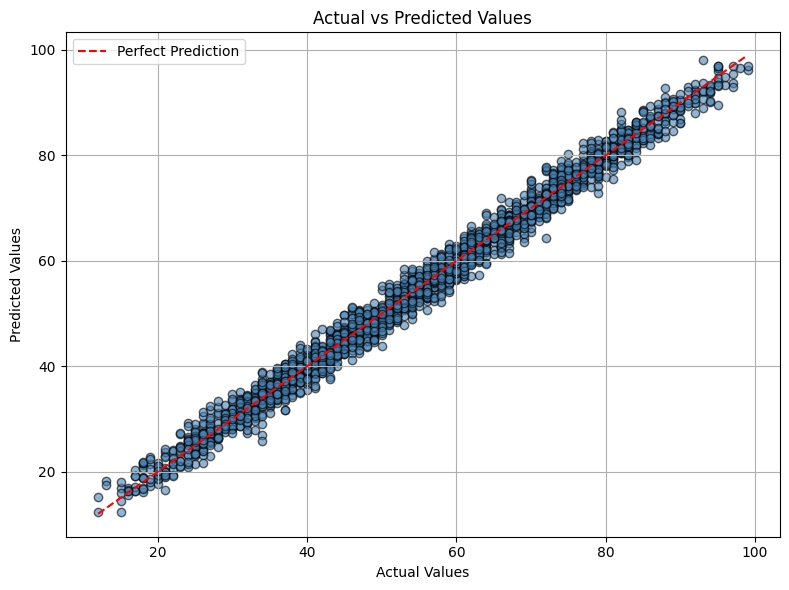

In [22]:
plot_predictions(y_test_vals, y_test_preds)

The scatter plot of actual versus predicted values shows how well the model is performing. The closer the points lie to the red dashed line (representing perfect predictions), the better the model’s accuracy. A tight clustering around this line indicates high predictive performance, while larger deviations suggest potential underfitting, overfitting, or the presence of noise in the data.

In our case we got a preety good model.

To conclude our analysis, we’ll evaluate the reliability of each coefficient in our model by calculating their standard errors. This step helps us understand how much each estimated coefficient might vary if we repeated the experiment with different data. Once we have these errors, we’ll perform hypothesis testing to determine whether each coefficient significantly contributes to the prediction. This is essential for interpreting which predictors truly matter in our regression model.

Earlier in this exercise, we explored some insights based on the correlation matrix:
Relationship of predictors with the Target Variable:
- Hours Studied and Previous Scores showed the strongest linear relationships with the Performance Index, with correlation coefficients of approximately 0.37 and 0.91, respectively. These predictors are expected to have a more significant impact on the model, compared to Sleep Hours and Sample Question Papers Practiced, which showed weaker correlations.

Now it’s time to test those assumptions using actual regression results.

The process for doing this is as follows:
- Take a boostrap sample
- Fit a model and take it's betas values
- Compute statistics for that samples.
- Do a p-value test

In [23]:
# Bootstrap sample function
def boostrap_sample(X: List[Vector]):
    """ Randomly take n = len(X) with replacement """
    return[random.choice(X) for _ in X]


# Define the predictors and target
predictors = ['hours_studied', 
              'previous_scores',
              'extracurricular_activities',
              'sleep_hours',
              'sample_question_papers_practiced']

target = 'performance_index'

bootstrap_betas = []

# We get a sample of betas, each group of Betas is calculated with s different bootstrap sample
for _ in range(15):
    sample = boostrap_sample(students_raw)

    # We took the data of the predictors we want for each student in training set
    xs_data = [list(zip(*(student.features_names, student.features_vector))) for student in sample]

    Xs = [
        [pairs[1] for pairs in student_data if pairs[0] in predictors]
            for student_data in xs_data
    ]

    ys = [student.target_value for student in sample]

    Xs_norm, _ = normalize_predictors(Xs,
                                predictors,
                                cols_to_normalize=['hours_studied',
                                                    'previous_scores',
                                                    'sleep_hours',
                                                    'sample_question_papers_practiced'])

    new_model = MultipleLinearRegression()
    new_model.fit(Xs_norm,ys, epochs=1000, batch_size=1000, learning_rate=0.001, alpha = 0)
    bootstrap_betas.append(new_model.betas)

Training model: 100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s, MSE=4.2746, R²=0.9881]  


Now that we’ve estimated the standard error of each coefficient using the bootstrap method, we can go one step further and evaluate their statistical significance.

To do this, we’ll use the normal approximation and calculate a two-tailed p-value for each estimated coefficient. This allows us to test the following hypothesis:
- Null hypothesis ($H_0$): The true coefficient is equal to 0 (i.e., it has no effect).
- Alternative hypothesis ($H_1$): The coefficient is different from 0.

Using the bootstrap distribution, we compute the mean and standard deviation (standard error) of each coefficient. Then, we plug those into our normal_p_value_test function, which:
1.	Calculates how far the observed coefficient is from 0 (in standard error units),
2.	Computes the two-tailed p-value,
3.	Plots the normal curve with rejection regions, and
4.	Highlights where our coefficient estimate lies on that distribution.

A small p-value (typically < 0.05) indicates that the coefficient is significantly different from zero, meaning it likely contributes meaningfully to the prediction.

This process gives us a statistical basis to determine whether the most correlated features (as seen in the correlation matrix) are also statistically significant predictors in the final model.

In [48]:

def normal_p_value_test(x: float, mean: float, std: float, alpha: float = 0.05, feature_name: str = ""):
    """
    Performs a two-tailed p-value test for a normal distribution and shows a plot.
    
    Args:
        x (float): The observed value
        mean (float): Mean of the normal distribution
        std (float): Standard deviation of the normal distribution
        alpha (float): Significance level (default: 0.05)

    Returns:
        float: p-value
    """
    # Calculate p-value (two-tailed)
    z = (x - mean) / std
    p_value = 2 * (1 - norm.cdf(abs(z)))
    
    # Plot the normal distribution
    x_vals = np.linspace(mean - 4*std, mean + 4*std, 1000)
    y_vals = norm.pdf(x_vals, mean, std)

    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, label="Normal Distribution", color="steelblue")

    # Shade rejection region
    crit_val = norm.ppf(1 - alpha/2, mean, std)
    plt.fill_between(x_vals, y_vals, where=(x_vals <= mean - crit_val), color='red', alpha=0.3, label='Rejection Region')
    plt.fill_between(x_vals, y_vals, where=(x_vals >= mean + crit_val), color='red', alpha=0.3)

    # Mark observed value
    plt.axvline(x, color='darkgreen', linestyle='--', linewidth=2, label=f"Observed x = {x}")
    
    plt.title(f"P-Value Test (p = {p_value:.5e}) - {feature_name}")
    plt.xlabel("x")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

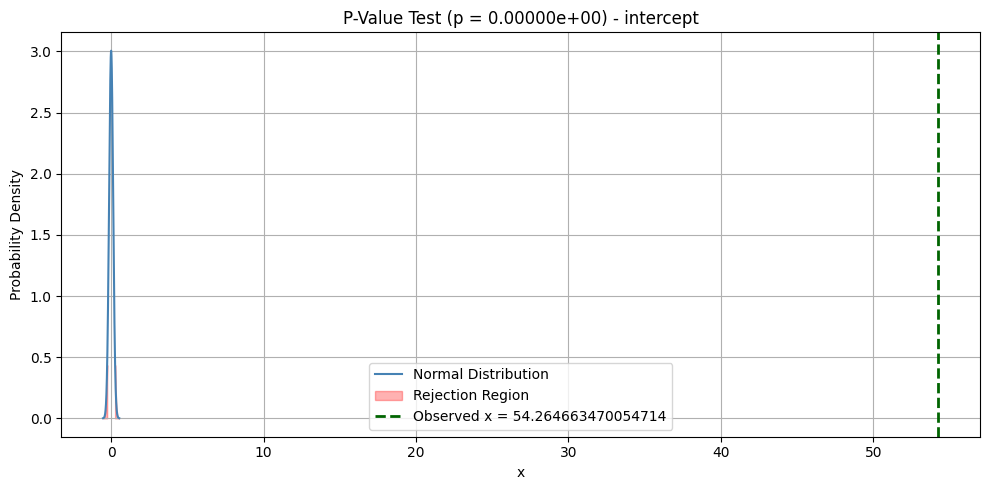

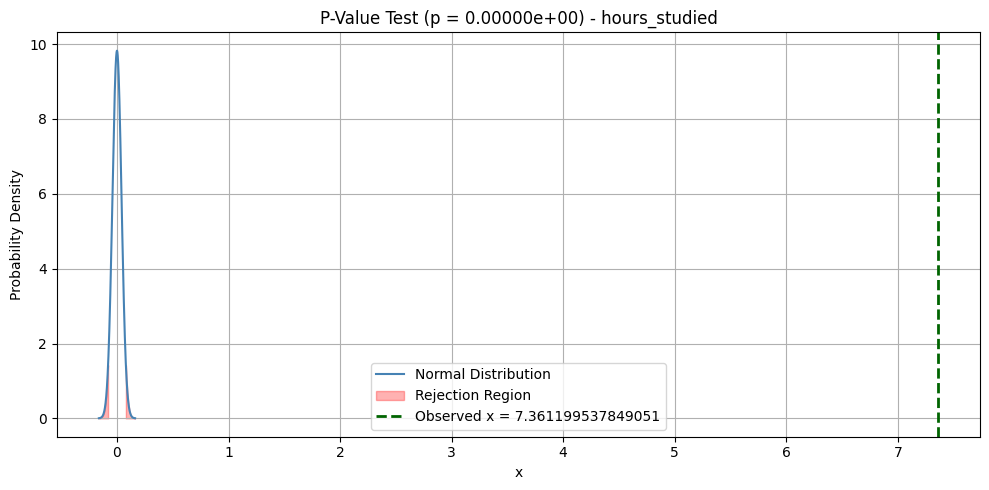

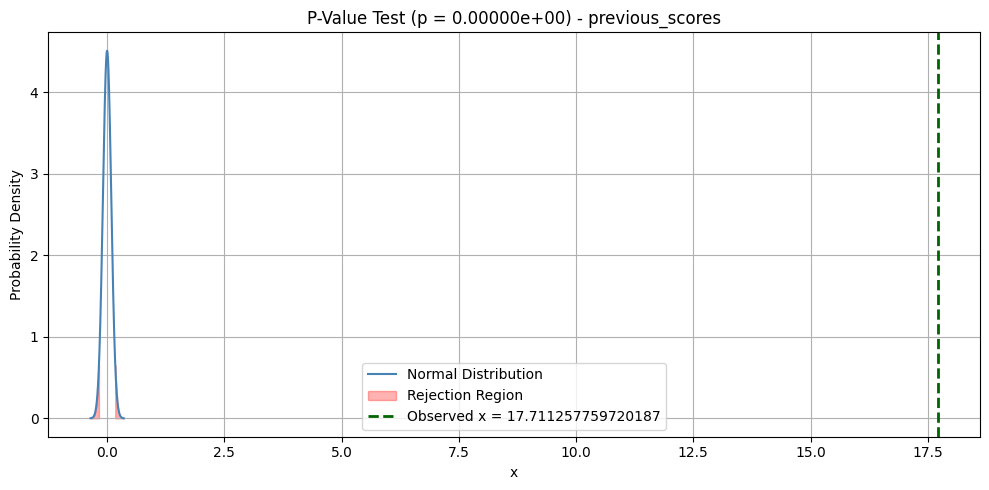

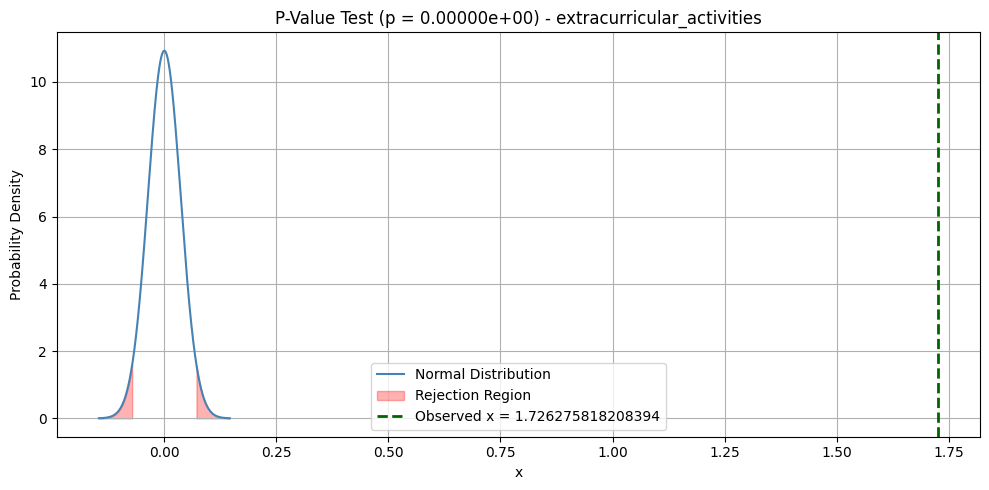

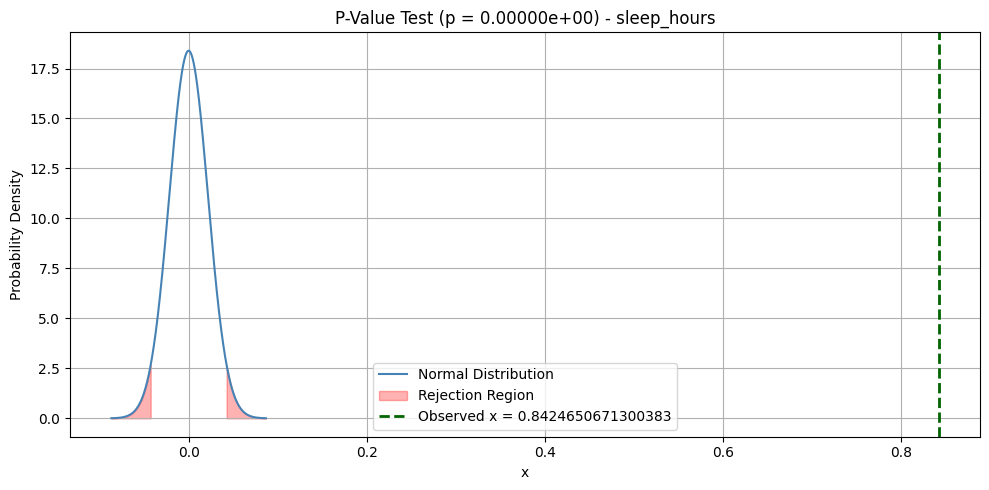

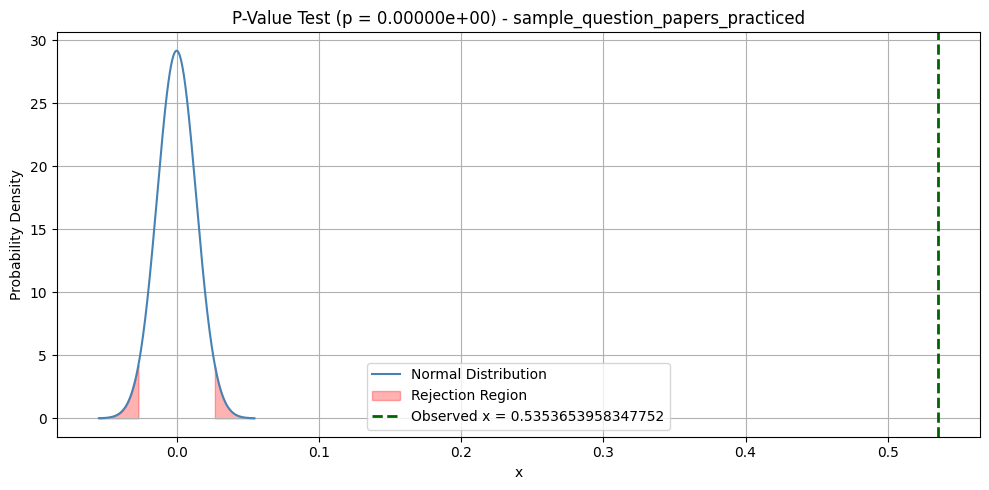

In [49]:
betas_stdvs = np.std(bootstrap_betas, axis = 0).tolist()
betas_means = np.mean(bootstrap_betas, axis = 0).tolist()
for b, std, mean, title in zip(model.betas, betas_stdvs, betas_means, ["intercept"] + predictors):
    normal_p_value_test(b, 0, std, 0.05, title)

As we can see, all the predictors have p-values less than 0.05. This suggests that the likelihood of observing such strong effects purely by chance is very low — in other words, these predictors are statistically significant.

### **Conclusion**

In this exercise, we successfully implemented and analyzed a Multiple Linear Regression model from scratch. Our approach included minibatch gradient descent, ridge regularization, and bootstrap-based estimation of standard errors for the coefficients.

We evaluated model performance using Mean Squared Error (MSE) and $R^2$, showing strong generalization on both the training and test datasets. Additionally, the bootstrap-based p-value tests confirmed all predictors were statistically significant.

The most important predictors—Previous Scores and Hours Studied—which showed the strongest correlations in our earlier analysis, remained statistically significant in the final model. This validates their strong relationship with the target variable. Moreover, all the predictors have p-values below 0.05, indicating that each contributes meaningfully to the model and should be considered relevant.

**How to interpret cofficients** 

Since the input features were normalized (i.e., transformed to have mean 0 and standard deviation 1), each coefficient represents the expected change in the target variable (still in original units) for a 1 standard deviation increase in the predictor.
*	Positive coefficients mean the target variable tends to increase when the predictor increases above its mean.
*	Negative coefficients indicate a decrease in the target variable.
*	Statistical significance (p-value) tells us whether this effect is likely to be real or due to chance.

Important: Due to normalization, coefficients cannot be interpreted in the original units of the predictors (e.g., hours or scores). Instead, they tell us which variables have more influence relative to each other by comparing standardized effects.